In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from category_encoders.target_encoder import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV,KFold, train_test_split)
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('amostra (1).csv')

In [4]:
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df.head()

,cod_pedido,cidade_destinatario,uf,grp_transportadora,dt_despacho_pedido,hr_despacho_pedido,dt_entrega_pedido,hr_entrega_pedido,dt_previsao_entrega_cliente,dt_criacao,dt_pagamento_pedido,flg_existem_ocorrencias,tp_praca,des_unidade_negocio,des_cd_origem,qtd_dias_tat,tp_performance_entrega
0,127995108-1,CURITIBA,PR,Transportadora 4,2023-12-04,05:56:39,2023-12-07,12:19:04,2023-12-07,2023-11-30,2023-11-30,Não,Capital,Multi,PR-Campina G. Sul,5.0,Entregue no Prazo
1,126433711-1,PARAUAPEBAS,PA,Transportadora 2,2023-11-21,12:39:55,2023-12-01,12:23:47,2023-12-11,2023-11-15,2023-11-17,Não,Interior,Mono,PR-Campina G. Sul,10.0,Entregue no Prazo
2,125177091-1,JACAREZINHO,PR,Transportadora 4,2023-10-28,10:12:24,2023-10-31,16:10:01,2023-11-06,2023-10-26,2023-10-27,Não,Interior,Mono,PR-Campina G. Sul,2.0,Entregue no Prazo
3,123168303-1,SÃO PAULO,SP,Transportadora 5,2023-08-23,17:52:06,2023-08-24,12:00:13,2023-08-24,2023-08-22,2023-08-22,Não,Capital,Multi,PR-Campina G. Sul,2.0,Entregue no Prazo
4,122901808,SAO LUIS,MA,Transportadora 3,2023-08-14,08:41:00,2023-08-23,15:22:59,2023-08-24,2023-08-13,2023-08-12,não,Capital,Multi,PR-Campina G. Sul,8.0,Entregue no Prazo


In [6]:
df['flg_existem_ocorrencias'] = df['flg_existem_ocorrencias'].replace('Não', 0).replace('não', 0).replace('Sim', 1).replace('sim', 1)

In [7]:
df['tp_performance_entrega'] = df['tp_performance_entrega'].replace('Entregue no Prazo', 0).replace('Fora do Prazo', 1)

In [8]:
df['dt_criacao'] = pd.to_datetime(df['dt_criacao'])
df['dt_pagamento_pedido'] = pd.to_datetime(df['dt_pagamento_pedido'])
df['intervalo_pedido_pagamento'] = (df['dt_pagamento_pedido'] - df['dt_criacao']).dt.days

In [9]:
df['dt_entrega_pedido'] = pd.to_datetime(df['dt_entrega_pedido'])
df['dt_previsao_entrega_cliente'] = pd.to_datetime(df['dt_previsao_entrega_cliente'])
df['intervalo_previsto_entregue'] = (df['dt_entrega_pedido'] - df['dt_previsao_entrega_cliente']).dt.days

In [10]:
df['intervalo_entrega'] = (df['dt_entrega_pedido'] - df['dt_criacao']).dt.days

In [11]:
df['mes_pedido'] = df['dt_criacao'].dt.month

In [12]:
def adiantou_ou_atrasou(intervalo):
    if intervalo < 0:
        return 2  # Atrasado
    if intervalo > 0:
        return 0
    else:
        return 1

In [13]:
df['status'] = df['intervalo_previsto_entregue'].apply(adiantou_ou_atrasou)

In [14]:
df['uf_origem'] = df['des_cd_origem'].str.split('-').str[0]

In [15]:
df.columns

Index(['cod_pedido', 'cidade_destinatario', 'uf', 'grp_transportadora',
       'dt_despacho_pedido', 'hr_despacho_pedido', 'dt_entrega_pedido',
       'hr_entrega_pedido', 'dt_previsao_entrega_cliente', 'dt_criacao',
       'dt_pagamento_pedido', 'flg_existem_ocorrencias', 'tp_praca',
       'des_unidade_negocio', 'des_cd_origem', 'qtd_dias_tat',
       'tp_performance_entrega', 'intervalo_pedido_pagamento',
       'intervalo_previsto_entregue', 'intervalo_entrega', 'mes_pedido',
       'status', 'uf_origem'],
      dtype='object')

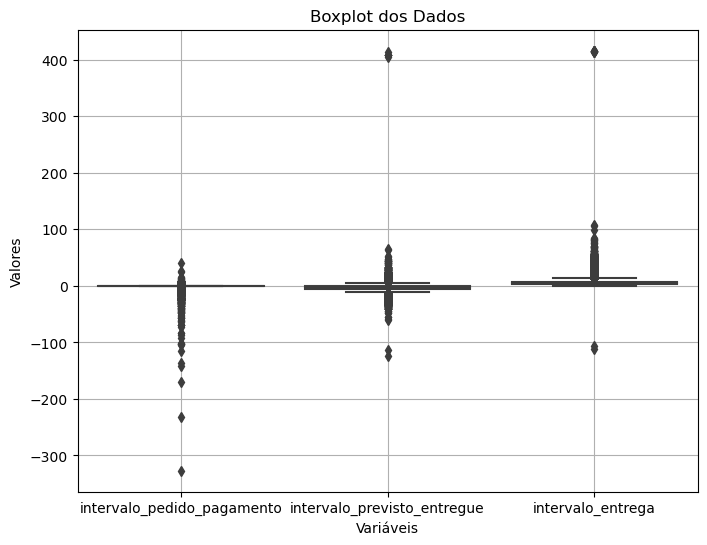

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[['intervalo_pedido_pagamento', 'intervalo_previsto_entregue', 'intervalo_entrega']])
plt.title('Boxplot dos Dados')
plt.xlabel('Variáveis')
plt.ylabel('Valores')
plt.grid(True)
plt.show()

In [17]:
def remove_outliers_df(df):
    for coluna in df.columns:
        df[coluna] = df[coluna][(df[coluna] <= 400)]
        df[coluna] = df[coluna][(df[coluna] >= -100)]
    return df

colunas_para_remover_outliers = ['intervalo_pedido_pagamento', 'intervalo_previsto_entregue', 'intervalo_entrega']
df[colunas_para_remover_outliers] = remove_outliers_df(df[colunas_para_remover_outliers])

In [18]:
df = df[df['intervalo_previsto_entregue'].notnull()] 
df = df[df['intervalo_pedido_pagamento'].notnull()] 

In [19]:
status_medio_trecho_transp = df.groupby(['grp_transportadora'])['status'].mean().reset_index(name='status_medio')

viagens_por_rota_transp = df.groupby(['uf_origem', 'uf', 'grp_transportadora']).size().reset_index(name='viagens')

status_rota_transp = df.groupby(['uf_origem', 'uf', 'grp_transportadora'])['status'].mean().reset_index(name='status_rota_transp')

viagens_atrasadas_rota_transp = df.groupby(['uf_origem', 'uf', 'grp_transportadora'])['tp_performance_entrega'].sum().reset_index(name='viagens_atrasadas_rota_transp')

df_merge = pd.merge(viagens_por_rota_transp, viagens_atrasadas_rota_transp, on=['uf_origem', 'uf', 'grp_transportadora'])

df_merge = pd.merge(df_merge, status_rota_transp, on=['uf_origem', 'uf', 'grp_transportadora'])

In [20]:
df_merge['percentual_atraso'] = df_merge.viagens_atrasadas_rota_transp / df_merge.viagens

In [21]:
total_por_trecho = df_merge.groupby(['grp_transportadora'])['viagens'].sum().reset_index(name='total_viagens_transp')

df_merge = pd.merge(df_merge, total_por_trecho, on=['grp_transportadora'])

df_merge['percentual_viagens_rota'] = df_merge.viagens / df_merge.total_viagens_transp

In [22]:
indice_transp_trecho = df.groupby(['grp_transportadora'])['status'].mean().reset_index(name='status_transportadora')

In [23]:
df_merge = pd.merge(df_merge, indice_transp_trecho, on=['grp_transportadora'])

In [24]:
df_merge

,uf_origem,uf,grp_transportadora,viagens,viagens_atrasadas_rota_transp,status_rota_transp,percentual_atraso,total_viagens_transp,percentual_viagens_rota,status_transportadora
0,PR,AC,Transportadora 1,79,21,1.316456,0.265823,199081,0.000397,1.915959
1,PR,AL,Transportadora 1,1491,18,1.963783,0.012072,199081,0.007489,1.915959
2,PR,AM,Transportadora 1,7,0,2.000000,0.000000,199081,0.000035,1.915959
3,PR,BA,Transportadora 1,3244,54,1.948829,0.016646,199081,0.016295,1.915959
4,PR,CE,Transportadora 1,1296,9,1.981481,0.006944,199081,0.006510,1.915959
...,...,...,...,...,...,...,...,...,...,...
220,PR,PR,Transportadora 6,1093,89,1.399817,0.081427,1093,1.000000,1.399817
221,PR,SP,Transportadora 5,16391,1782,1.353182,0.108718,22129,0.740702,1.365177
222,SP,SP,Transportadora 5,5738,1086,1.399442,0.189265,22129,0.259298,1.365177
223,SP,RJ,Transportadora 8,41,3,1.731707,0.073171,619,0.066236,1.827141


In [25]:
viagens_por_mes_indice_atrsos = df.groupby(['mes_pedido'])['intervalo_previsto_entregue'].mean().reset_index()

In [26]:
viagens_por_mes_indice_atrsos.columns = ['mes_pedido', 'indice_mes']

In [27]:
df = pd.merge(df, viagens_por_mes_indice_atrsos, on=['mes_pedido'])

In [28]:
final = pd.merge(df, df_merge, on=['grp_transportadora', 'uf', 'uf_origem'])

In [29]:
final.columns

Index(['cod_pedido', 'cidade_destinatario', 'uf', 'grp_transportadora',
       'dt_despacho_pedido', 'hr_despacho_pedido', 'dt_entrega_pedido',
       'hr_entrega_pedido', 'dt_previsao_entrega_cliente', 'dt_criacao',
       'dt_pagamento_pedido', 'flg_existem_ocorrencias', 'tp_praca',
       'des_unidade_negocio', 'des_cd_origem', 'qtd_dias_tat',
       'tp_performance_entrega', 'intervalo_pedido_pagamento',
       'intervalo_previsto_entregue', 'intervalo_entrega', 'mes_pedido',
       'status', 'uf_origem', 'indice_mes', 'viagens',
       'viagens_atrasadas_rota_transp', 'status_rota_transp',
       'percentual_atraso', 'total_viagens_transp', 'percentual_viagens_rota',
       'status_transportadora'],
      dtype='object')

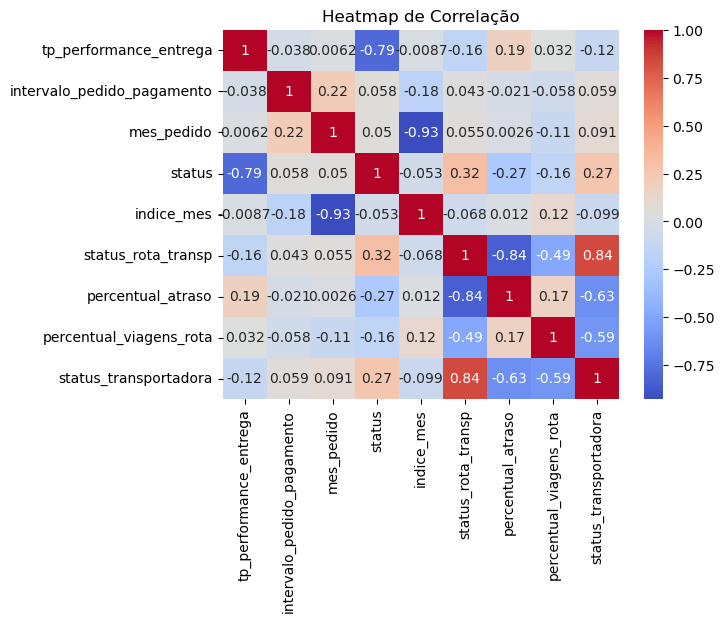

In [30]:
correlacao = final[[
       'tp_performance_entrega', 'intervalo_pedido_pagamento',
         'mes_pedido',
       'status','indice_mes', 
       'status_rota_transp',
       'percentual_atraso', 'percentual_viagens_rota',
       'status_transportadora']].corr()
sns.heatmap(correlacao, annot=True, cmap='coolwarm')
plt.title('Heatmap de Correlação')
plt.show()

In [31]:
final = final[['uf', 'grp_transportadora','tp_performance_entrega', 'intervalo_pedido_pagamento',
       'indice_mes', 'tp_praca',
       'des_unidade_negocio', 
       'status_rota_transp','uf_origem',
       'percentual_viagens_rota']]

In [32]:
final.head()

,uf,grp_transportadora,tp_performance_entrega,intervalo_pedido_pagamento,indice_mes,tp_praca,des_unidade_negocio,status_rota_transp,uf_origem,percentual_viagens_rota
0,PR,Transportadora 4,0,0.0,-4.102798,Capital,Multi,1.631596,PR,0.263662
1,PR,Transportadora 4,0,0.0,-4.102798,Interior,Mono,1.631596,PR,0.263662
2,PR,Transportadora 4,0,0.0,-4.102798,Interior,Mono,1.631596,PR,0.263662
3,PR,Transportadora 4,0,0.0,-4.102798,Reg. Metropolitana,Multi,1.631596,PR,0.263662
4,PR,Transportadora 4,0,0.0,-4.102798,Interior,Mono,1.631596,PR,0.263662


In [33]:
final.columns

Index(['uf', 'grp_transportadora', 'tp_performance_entrega',
       'intervalo_pedido_pagamento', 'indice_mes', 'tp_praca',
       'des_unidade_negocio', 'status_rota_transp', 'uf_origem',
       'percentual_viagens_rota'],
      dtype='object')

In [34]:
def split(data, target_variable):
    X_train, X_test, y_train, y_test = train_test_split(
                                                    data[columns_to_model], 
                                                    data[target_variable], 
                                                    stratify=data[target_variable], 
                                                    random_state=42
                                                    )
    return X_train, X_test, y_train, y_test

In [35]:
columns_to_model = ['uf', 'grp_transportadora', 
       'intervalo_pedido_pagamento', 'indice_mes', 'tp_praca',
       'des_unidade_negocio', 'status_rota_transp', 'uf_origem',
       'percentual_viagens_rota']
X_train, X_test, y_train, y_test = train_test_split(final[columns_to_model], final['tp_performance_entrega'], test_size=0.2, random_state=42, stratify=final[['uf', 'uf_origem']])

In [36]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [37]:
from sklearn.preprocessing import MinMaxScaler
selected_columns = ['intervalo_pedido_pagamento','indice_mes','status_rota_transp','percentual_viagens_rota']
X_train_subset = X_train[selected_columns]
scaler = MinMaxScaler()
X_train[['intervalo_pedido_pagamento_s','indice_mes_s','status_rota_transp_s','percentual_viagens_rota_s']] = pd.DataFrame(scaler.fit_transform(X_train_subset), columns=selected_columns)
X_train = X_train.drop(['intervalo_pedido_pagamento','indice_mes','status_rota_transp','percentual_viagens_rota'], axis=1)

In [38]:
min_max_params = pd.DataFrame({
    'min': scaler.data_min_,
    'max': scaler.data_max_
}, index=selected_columns)
min_max_params.to_csv('min_max_params.csv', index=False)

In [39]:
from sklearn.preprocessing import MinMaxScaler
selected_columns = ['intervalo_pedido_pagamento','indice_mes','status_rota_transp','percentual_viagens_rota']
X_test_subset = X_test[selected_columns]
scaler = MinMaxScaler()
X_test[['intervalo_pedido_pagamento_s','indice_mes_s','status_rota_transp_s','percentual_viagens_rota_s']] = pd.DataFrame(scaler.fit_transform(X_test_subset), columns=selected_columns)
X_test = X_test.drop(['intervalo_pedido_pagamento','indice_mes','status_rota_transp','percentual_viagens_rota'], axis=1)

In [40]:
treino = pd.concat([X_train,pd.Series(list(y_train.values))], axis=1)

In [41]:
treino = treino.rename(columns={0: 'tp_performance_entrega'})

In [42]:
treino.to_csv('dataset_treinamento.csv', index=False)

In [43]:
teste = pd.concat([X_test, pd.Series(list(y_test.values))], axis=1)

In [44]:
teste = teste.rename(columns={0: 'tp_performance_entrega'})

In [45]:
teste.to_csv('dataset_teste.csv', index=False)